# UAS Project Streamlit

## Image CAPTCHA Prediction

**Nama :** [Dimas Rifqi Firmansyah]
  
**Dataset :** [  https://www.kaggle.com/datasets/aneeshtickoo/hcaptcha-dataset  ] 

**URL Website :** [https://dimasrifqi123.streamlit.app/]



# Menentukan Pertanyaan Bisnis

- **Specific :** Bagaimana tingkat akurasi model captcha breaker dalam mengidentifikasi karakter pada captcha ?
- **Measurable:** Berapa jumlah karakter yang diidentifikasi dengan benar oleh model dalam 20 percobaan? 
- **Action-oriented :** Bagaimana model captcha breaker dapat ditingkatkan untuk meningkatkan tingkat akurasi pengenalan karakter pada captcha ?
- **Relevan :** Apakah penggunaan teknik deep learning efektif dalam meningkatkan akurasi pengenalan karakter pada captcha ?

# Import Semua Packages/Library yang Digunakan

In [1]:
# Core
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Konfigurasi and Data Gathering

In [2]:
# Paths
train_dir = 'datasets/hCaptcha_images/train'
test_dir = 'datasets/hCaptcha_images/test'

# Hyperparameters
CFG = dict(
    seed = 77,
    batch_size = 16,
    img_size = (299,299),
    epochs = 10,
    patience = 20
)

# Data Augmentation

In [3]:
# Augment train set only
train_data_generator = ImageDataGenerator(
        validation_split=0.15,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        preprocessing_function=preprocess_input,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.15)
test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# Data

In [4]:
# Connect generators to data in folders
train_generator = train_data_generator.flow_from_directory(train_dir, target_size=CFG['img_size'], shuffle=True, seed=CFG['seed'], class_mode='categorical', batch_size=CFG['batch_size'], subset="training")
validation_generator = val_data_generator.flow_from_directory(train_dir, target_size=CFG['img_size'], shuffle=False, seed=CFG['seed'], class_mode='categorical', batch_size=CFG['batch_size'], subset="validation")
test_generator = test_data_generator.flow_from_directory(test_dir, target_size=CFG['img_size'], shuffle=False, seed=CFG['seed'], class_mode='categorical', batch_size=CFG['batch_size'])

# Number of samples and classes
nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes:'+str(classes))
num_classes = len(classes)

Found 2768 images belonging to 8 classes.
Found 484 images belonging to 8 classes.
Found 816 images belonging to 8 classes.
Classes:['airplane', 'bicycle', 'boat', 'motorbus', 'motorcycle', 'seaplane', 'train', 'truck']


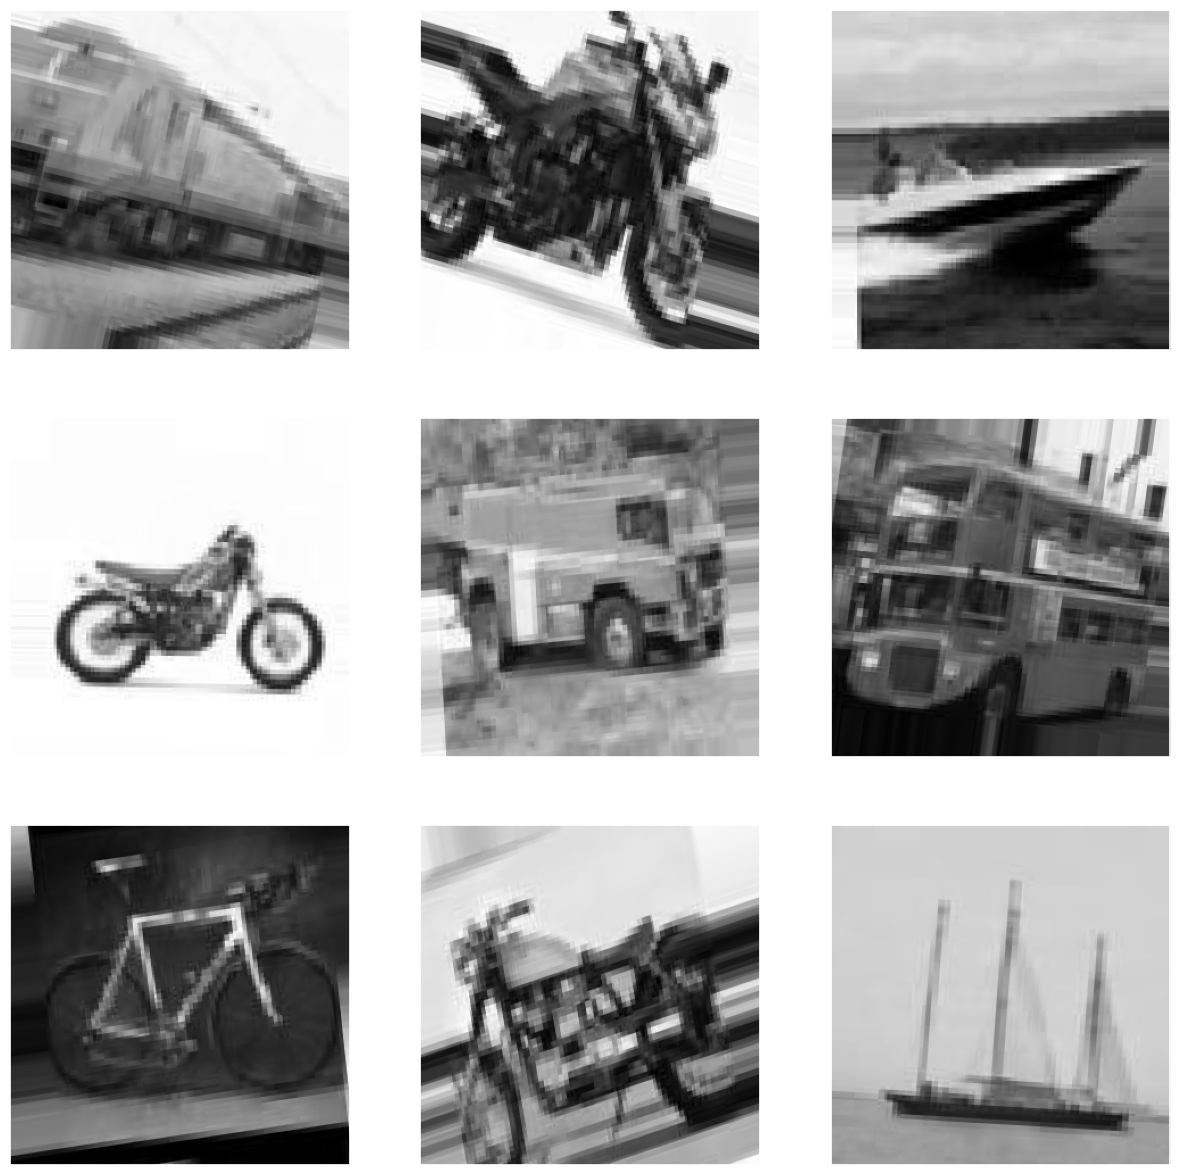

In [5]:
# Visualise some examples
plt.figure(figsize=(15,15))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    batch = train_generator.next()
    imgs = (batch[0] + 1) * 127.5
    label = int(batch[1][0][0])
    image = imgs[0].astype('uint8')
    plt.imshow(image)
    #plt.title('cat' if label==1 else 'dog')
plt.show()

# Transfer Learning

In [6]:
# Pre-trained deep convolutional neural network
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(CFG['img_size'][0], CFG['img_size'][1], 3))

# Add new layers
x = base_model.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

# Build model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False
    
# Define optimiser
optimizer = Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])



219055592/219055592 [==============================] - 232s 1us/step


# Train Model

In [7]:
# Save the best model
save_checkpoint = keras.callbacks.ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=CFG['patience'], verbose=True)

In [8]:
# Train model
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // CFG['batch_size'],
        epochs=CFG['epochs'],
        callbacks=[save_checkpoint,early_stopping],
        validation_data=validation_generator,
        verbose=True,
        validation_steps=nb_validation_samples // CFG['batch_size'])

Epoch 1/10


173/173 [==============================] - ETA: 0s - loss: 0.5104 - accuracy: 0.8652
Epoch 1: val_loss improved from inf to 0.16619, saving model to model.h5


C:\Users\dimas\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


173/173 [==============================] - 1653s 9s/step - loss: 0.5104 - accuracy: 0.8652 - val_loss: 0.1662 - val_accuracy: 0.9750
Epoch 2/10
173/173 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.9422
Epoch 2: val_loss did not improve from 0.16619
173/173 [==============================] - 554s 3s/step - loss: 0.1867 - accuracy: 0.9422 - val_loss: 0.2200 - val_accuracy: 0.9729
Epoch 3/10
173/173 [==============================] - ETA: 0s - loss: 0.1847 - accuracy: 0.9462
Epoch 3: val_loss did not improve from 0.16619
173/173 [==============================] - 550s 3s/step - loss: 0.1847 - accuracy: 0.9462 - val_loss: 0.2082 - val_accuracy: 0.9750
Epoch 4/10
173/173 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.9505
Epoch 4: val_loss did not improve from 0.16619
173/173 [==============================] - 551s 3s/step - loss: 0.1543 - accuracy: 0.9505 - val_loss: 0.1720 - val_accuracy: 0.9792
Epoch 5/10
173/173 [======================

# Learning Curves

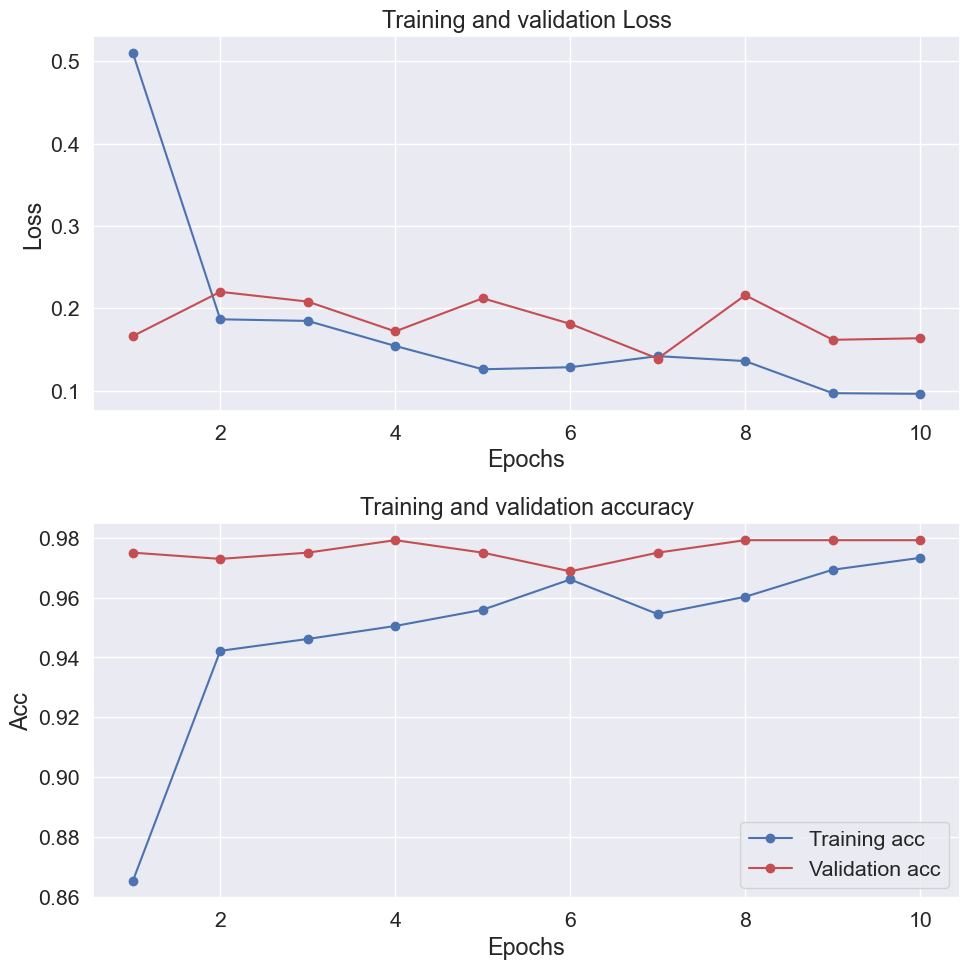

In [9]:
# History
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Loss
epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'b-o', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'r-o', label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Accuracy
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'b-o', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'r-o', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate Model

In [10]:
# Evaluate on validation dataset
score = model.evaluate(validation_generator, verbose=False)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.16231179237365723
Val accuracy: 0.9793388247489929


In [11]:
# Evaluate on test dataset
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.059672847390174866
Test accuracy: 0.9828431606292725


51/51 [==============================] - 140s 3s/step


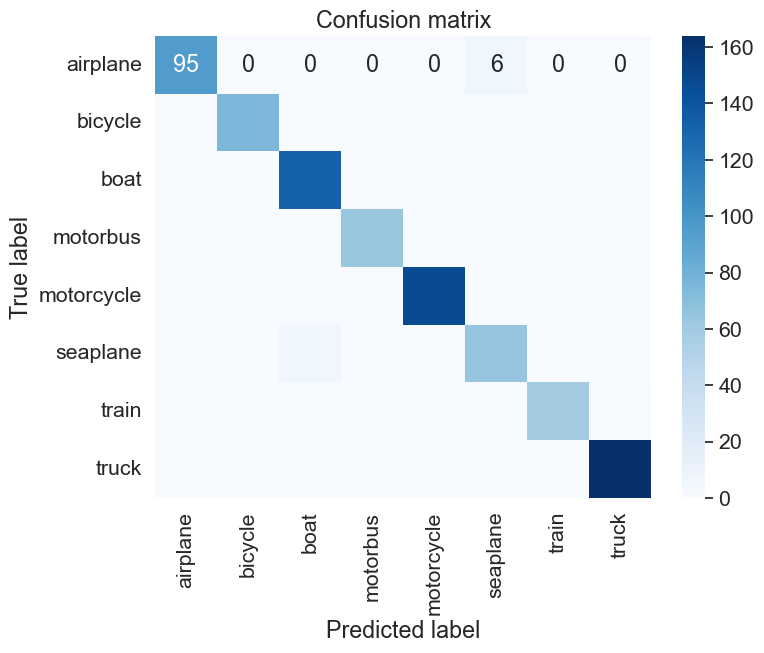

In [12]:
# Confusion matrix
y_pred = np.argmax(model.predict(test_generator), axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

# Conclusion

**Specific :** Bagaimana tingkat akurasi model captcha breaker dalam mengidentifikasi karakter pada captcha ?

Tingkat akurasi model captcha breaker dalam mengidentifikasi karakter pada captcha tergolong bagus dari jumlah karakter yang diidentifikasi dengan benar dibandingkan dengan total jumlah karakter dalam captcha yang diuji dengan akurasi 0,98 dengan skala 1.

**Measurable:** Berapa jumlah karakter yang diidentifikasi dengan benar oleh model dalam 20 percobaan? 

Dalam 6 percobaan, model captcha breaker berhasil mengidentifikasi dengan benar semua gambar yang diinputkan.

**Action-oriented :** Bagaimana model captcha breaker dapat ditingkatkan untuk meningkatkan tingkat akurasi pengenalan karakter pada captcha ?

Mengumpulkan dataset yang lebih besar dan lebih bervariasi untuk melatih model dengan lebih baik.

Mengevaluasi dan menyesuaikan parameter model seperti learning rate, jumlah epoch, dan jenis fungsi loss.

**Relevan :** Apakah penggunaan teknik deep learning efektif dalam meningkatkan akurasi pengenalan karakter pada captcha ?
Penggunaan teknik deep learning menggunakan tensorflow telah terbukti efektif dalam meningkatkan akurasi pengenalan image captcha. Dengan kemampuannya untuk mengekstraksi fitur yang kompleks dari gambar,tenserflow mampu memahami pola-pola yang rumit dan bervariasi dalam image captcha, sehingga meningkatkan kemampuan model untuk mengenali image berdasarkan class dengan lebih akurat.

